# **Forest Clear-Cut Detection using Sentinel-2 Time Series**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kenoz/SITS_utils/blob/main/docs/source/tutorials/colab_sits_ex05.ipynb)

---
We aim to detect tree cover loss by identifying rapid drops in univariate time-series data (e.g. Sentinel-2 indices). This notebook uses an adapted version of the [ClearCutsDetection](https://gitlab.irstea.fr/remi.cresson/ClearCutsDetection) OTB (Orfeo ToolBox) application developed by R. Cresson (INRAE-UMR TETIS), now available as a built-in feature of the `sits` package.

---
## 1. Installation of SITS package and its depedencies

First, install `sits` package with [pip](https://pypi.org/project/SITS/). We also need some other packages for displaying data.

In [1]:
#!pip install -q --upgrade sits

Now we can import `sits` modules and some other libraries.

In [ ]:
import os
from sits import sits, analysis
import geopandas as gpd
from shapely.geometry import box
from datetime import datetime
import matplotlib.pyplot as plt

We also create a directory to store the output files.

In [3]:
out_dir = 'test_data'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

---
## 2. Study area

We have selected a study site in the **Morvan Regional Natural Park**, France. The workflow requires two spatial definitions: a bounding box in WGS84 (lat/lon) for querying the STAC catalog, and a projected version in EPSG:3035 to define the output CRS for analysis.

In [4]:
# area of study
bbox_4326 = [4.000000, 47.000000, 4.100000, 47.050000]

print(f"bbox in EPSG:4326: {bbox_4326}")
geom = box(*bbox_4326)
# Load into a GeoDataFrame and set the original CRS (WGS84)
gdf = gpd.GeoDataFrame({'geometry': [geom]}, crs="EPSG:4326")

# Transform to EPSG:3035
gdf_3035 = gdf.to_crs("EPSG:3035")
# Extract the bounds as a list: [minx, miny, maxx, maxy]
bbox_3035 = list(gdf_3035.total_bounds)
print(f"bbox in EPSG:3035: {bbox_3035}")

bbox in EPSG:4326: [4.0, 47.0, 4.1, 47.05]
bbox in EPSG:3035: [3864842.734478761, 2671911.2763597923, 3872853.778674381, 2678061.0457251826]


In [5]:
# open an interactive map directly in the notebook
gdf.explore()

```
<div style="text-align: center;">
  <img src="img/cc_area.png" alt="clear-cut method" width="500">
</div>
```

---
## 3. Pre-processing: STAC Queries and Forest Masking

### 3.1. Sentinel-2 time series

The retrieval process involves collecting Sentinel-2 (Level-2A) imagery acquired between January 1, 2019, and January 1, 2025, filtered for a cloud cover of less than 20%. We then construct a four-band geospatial data cube, consisting of B04 (Red), B08 (NIR), B11 (SWIR), and SCL (Scene Classification Layer), reprojected to EPSG:3035 at a 10m spatial resolution. During this process, radiometric offsets are corrected. Finally, the SCL layer is utilized to mask invalid pixels, such as clouds and cloud shadows (refer to [tutorial 01](https://github.com/kenoz/SITS_utils/blob/186dbf13de0289707a8a2d9c7f3706fc96591d51/docs/source/tutorials/colab_sits_ex01.ipynb) for additional details).

In [6]:
bands = ['B04', 'B08', 'B11', 'SCL']
cloud_cover = 20

ts_S2 = sits.StacAttack(provider='mpc',
                        collection='sentinel-2-l2a',
                        bands=bands)

# search of items based on bbox coordinates and time interval criteria
ts_S2.searchItems(bbox_4326,
                  date_start=datetime(2019, 1, 1),
                  date_end=datetime(2025, 1, 1),
                  query={"eo:cloud_cover": {"lt": cloud_cover}})

# load of the time series in a lazy way
ts_S2.loadCube(bbox_3035, resolution=10, crs_out=3035)
ts_S2.fixS2shift()

ts_S2.mask_conf(mask_values=[0, 1, 3, 6, 8, 9, 10, 11])
ts_S2.mask_apply()

ts_S2.cube

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 201, y: 616, x: 802)
Coordinates:
  * y            (y) float64 5kB 2.678e+06 2.678e+06 ... 2.672e+06 2.672e+06
  * x            (x) float64 6kB 3.865e+06 3.865e+06 ... 3.873e+06 3.873e+06
  * time         (time) datetime64[ns] 2kB 2019-02-05T10:52:31.024000 ... 202...
    spatial_ref  int64 8B 0
Data variables:
    B04          (time, y, x) float32 397MB dask.array<chunksize=(1, 612, 612), meta=np.ndarray>
    B08          (time, y, x) float32 397MB dask.array<chunksize=(1, 612, 612), meta=np.ndarray>
    B11          (time, y, x) float32 397MB dask.array<chunksize=(1, 612, 612), meta=np.ndarray>
    SCL          (time, y, x) float32 397MB dask.array<chunksize=(1, 612, 612), meta=np.ndarray>

### 3.2. Forest mask

The algorithm detects abrupt signal drops regardless of land cover type. Therefore, a forest mask is required to focus the detection exclusively on forested regions and avoid false positives in other areas. For this example, we use the [ESRI 10 meter land cover](https://planetarycomputer.microsoft.com/dataset/io-lulc#overview) product. This dataset provides a global estimates of 10-class land use/land cover (LULC) for 2020, derived from ESA Sentinel-2 imagery at 10m resolution.

Datetime parsing failed: time data '2020-06-01T00:00:00Z' does not match format '%Y-%m-%dT%H:%M:%S.%fZ'


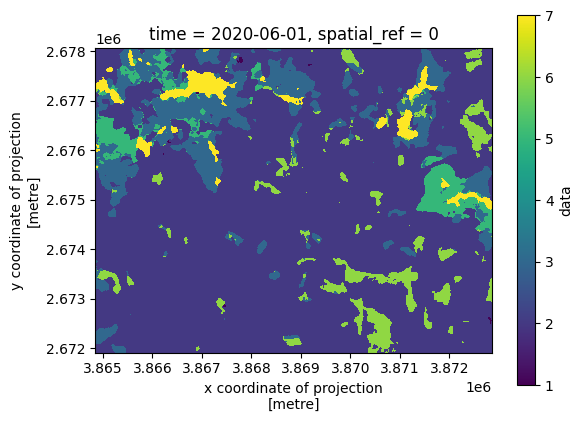

In [7]:
lulc = sits.StacAttack(provider='mpc',
                       collection='io-lulc',
                       bands=['data'])
lulc.searchItems(bbox_4326,
                 date_start=datetime(2019, 1, 1),
                 date_end=datetime(2020, 12, 31))
lulc.loadCube(bbox_3035, resolution=10, crs_out=3035)

lulc.cube.data.plot()
plt.axis('scaled')
plt.show()

Like most land-cover classifications, this dataset uses integers to represent different classes. We need to determine the specific code used for forest pixels to isolate them for our analysis.

In [8]:
for index, value in enumerate(lulc.items_prop["label:classes"][0][0]["classes"]):
    print(f"Class index: {index}, Value: {value}")

Class index: 0, Value: nodata
Class index: 1, Value: water
Class index: 2, Value: trees
Class index: 3, Value: grass
Class index: 4, Value: flooded veg
Class index: 5, Value: crops
Class index: 6, Value: scrub
Class index: 7, Value: built area
Class index: 8, Value: bare
Class index: 9, Value: snow/ice
Class index: 10, Value: clouds


Following the ESRI 10m LULC scheme, the **value 2** corresponds to the **Forest class**.

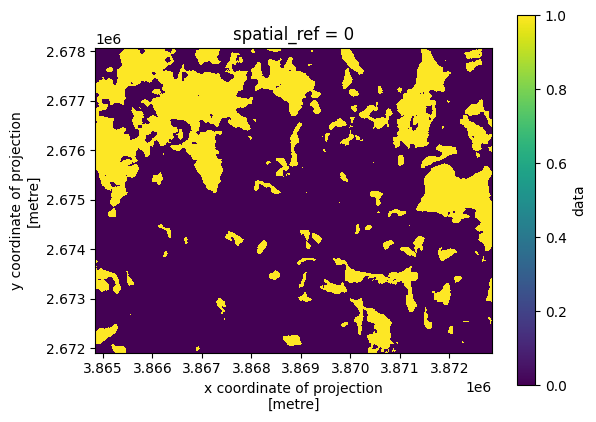

In [9]:
forest_mask = (lulc.cube.data != 2).squeeze(drop=True)

forest_mask.plot()
plt.axis('scaled')
plt.show()

To constrain the satellite data using the forest mask, we utilize again the `StacAttack.mask_conf()` method by passing our boolean array to the `mask_array` parameter.

In [10]:
ts_S2.mask_conf(mask_array=forest_mask)
ts_S2.mask_apply()

---
## 4. Clear-cut mapping

### 4.1. A few words about the method
This detection method exploits vegetation index time series to map forest clear-cuts by identifying abrupt temporal declines. The algorithm uses a convolution-based approach to calculate a value $d$, which quantifies the transition of a pixel's index value from a high, stable forest signal to a low post-harvest signal. A clear-cut is detected whenever $d$ exceeds a configurable threshold $d_{THRES}$ at a specific date $t_i$. The intensity of the drop is categorized into "strong" or "very strong" magnitudes, and metadata, such as the number of samples used for detection, are recorded to validate the result. The algorithm processes each unmasked pixel independently as a temporal stack. Originally implemented via the Orfeo ToolBox ([OTB](https://www.orfeo-toolbox.org/)), this approach is now available in `sits` package.

<div style="text-align: center;">
  <img src="img/clearcut.png" alt="clear-cut method" width="400">
</div>
<div style="text-align: center;">
  <sup>Clear-cut detection in one pixel of Sentinel-2 time series. <i>Only valid pixel values are shown. The top chart presents the NDVI time series, the bottom chart presents the “NDVI drop” time series. Maximum drop greater than the specified threshold $d_{THRES}$ is labeled as clear-cut.</i></sup>
</div>

source:

> K. Ose and R. Cresson, "Clear-Cuts Detection Services for The Monitoring Needs of the French Ministry of Agriculture," *IGARSS 2019 - 2019 IEEE International Geoscience and Remote Sensing Symposium*, Yokohama, Japan, 2019, pp. 4284-4287, [doi: 10.1109/IGARSS.2019.8897825](https://ieeexplore.ieee.org/document/8897825).

### 4.2. Time series of Vegetation Index
As explained in [tutorial 03](https://github.com/kenoz/SITS_utils/blob/main/docs/source/tutorials/colab_sits_ex03.ipynb), `sits` utilizes the `spyndex` package to calculate spectral indices. In this step, we generate a time series of NDMI.


In [11]:
band_mapping = {'B': 'B02', 'G': 'B03', 'R': 'B04', 'N': 'B08', 'S1': 'B11'}
index = 'NDMI'

ts_S2.spectral_index(index, band_mapping)

### 4.3. Clear-cuts detection

The clear-cut detection logic is implemented within the `Clearcut` class of the `sits.analysis` module. This class is designed to detect abrupt changes in univariate time series (e.g., spectral indices like NDVI) by comparing observations within two sliding temporal windows:

- Backward Window: summarizes past observations to establish a baseline.
- Forward Window: summarizes upcoming observations to detect potential drops.

A change is flagged when the forward window shows a significant decline relative to the backward window, exceeding a user-defined threshold. The detection process follows two mandatory stages:

1. `Clearcut.season_of_interest()`: this method filters the data cube to retain only observations within a specific yearly range. By default, we use start="06-01" and end="08-31" to focus on the summer season. This is crucial for studying deciduous broadleaf forests; during winter, the natural loss of leaves significantly impacts vegetation index values, which frequently leads to false detections.
2. `Clearcut.detect_anomalies()`: this core method identifies anomalies by calculating the magnitude of change (the absolute difference between the means of the backward and forward windows). An anomaly is recorded if this magnitude exceeds the primary threshold.

Key Parameters:
> - thresholds (list, default [0.2, 0.3, 0.4]): Values used to classify the severity of the anomaly.
> - window_backward / window_forward (int): The temporal extent (in days) for the past (720d) and future (60d) baselines.
> - min_obs_backward / min_obs_forward (int): The minimum required valid pixels within those windows. If these are not met, the algorithm searches beyond the window limits, and the inrange flag is set to False.
> - out_crs: The target CRS for the output (default "EPSG:3035").

Output Dataset: the resulting `Clearcut.detection` is an `xarray.Dataset` containing:
> - magnitude_first / max / last: The intensity of the first, strongest, and most recent anomalies.
> - date_first / max / last: The corresponding dates (Unix epoch) of these events.
> - mask: A binary layer indicating where an anomaly was detected.
> - inrange: A flag indicating if the detection stayed within the defined temporal window constraints.
> - classif: A categorical layer classifying the event based on the provided thresholds (low, medium and high confidence).

Optionally, you can export the result to a NetCDF file using `Clearcut.detection.to_netcdf()` method.

In [ ]:
cc_detect = analysis.ClearCut(ts_S2.indices.NDMI)
cc_detect.season_of_interest()
cc_detect.detect_anomalies(thresholds=[0.25, 0.35, 0.45],
                           min_obs_backward=5,
                           min_obs_forward=5)

cc_detect.detection.to_netcdf(os.path.join(out_dir, f"clearcut_example.nc"))

The output `xarray.Dataarray` includes 9 variables:

In [13]:
cc_detect.detection

<xarray.Dataset> Size: 17MB
Dimensions:          (y: 616, x: 802)
Coordinates:
  * y                (y) float64 5kB 2.678e+06 2.678e+06 ... 2.672e+06 2.672e+06
  * x                (x) float64 6kB 3.865e+06 3.865e+06 ... 3.873e+06 3.873e+06
    time             datetime64[ns] 8B 2019-06-02T10:40:31.024000
    spatial_ref      int64 8B 0
Data variables:
    magnitude_first  (y, x) float32 2MB 0.3028 0.3303 0.5003 ... nan nan nan
    date_first       (y, x) float32 2MB 1.878e+04 1.878e+04 ... nan nan
    magnitude_max    (y, x) float32 2MB 0.3028 0.3303 0.5003 ... nan nan nan
    date_max         (y, x) float32 2MB 1.878e+04 1.878e+04 ... nan nan
    magnitude_last   (y, x) float32 2MB 0.2884 0.2538 0.304 ... nan nan nan
    date_last        (y, x) float32 2MB 1.879e+04 1.879e+04 ... nan nan
    mask             (y, x) bool 494kB True True True True ... False False False
    inrange          (y, x) bool 494kB True True True True ... True True True
    classif          (y, x) int64 4MB 1 1 3 2 3 3 3 3 0 0 ... 0 0 0 0 0 0 0 0 0

Now we can visualize the results using an interactive Folium map. The following variables are displayed:
- `date_max`: The image acquisition date on which the maximum magnitude drop was detected within the time series.
- `classif`: A classification result where 1 represents low magnitude, 2 medium magnitude, and 3 high magnitude. These classes can be interpreted as the level of detection confidence.
- `magnitude_max`: The maximum recorded value of the magnitude drop.


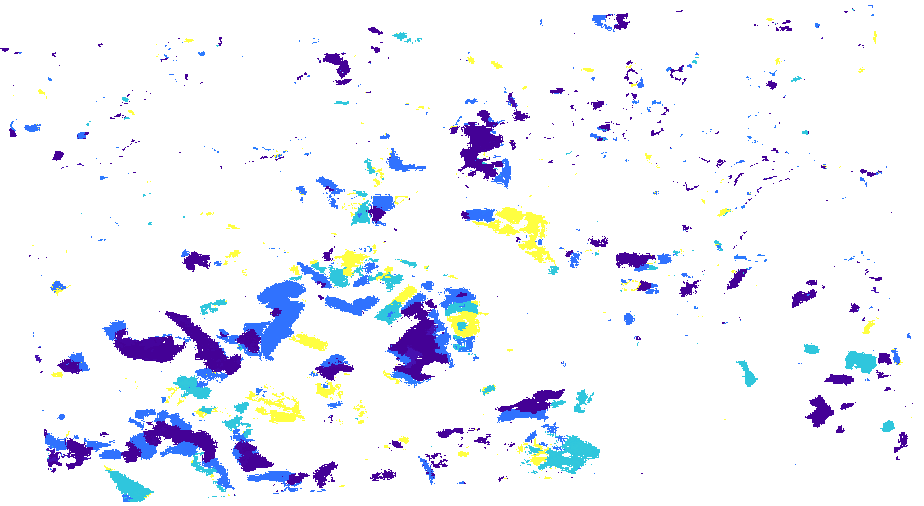
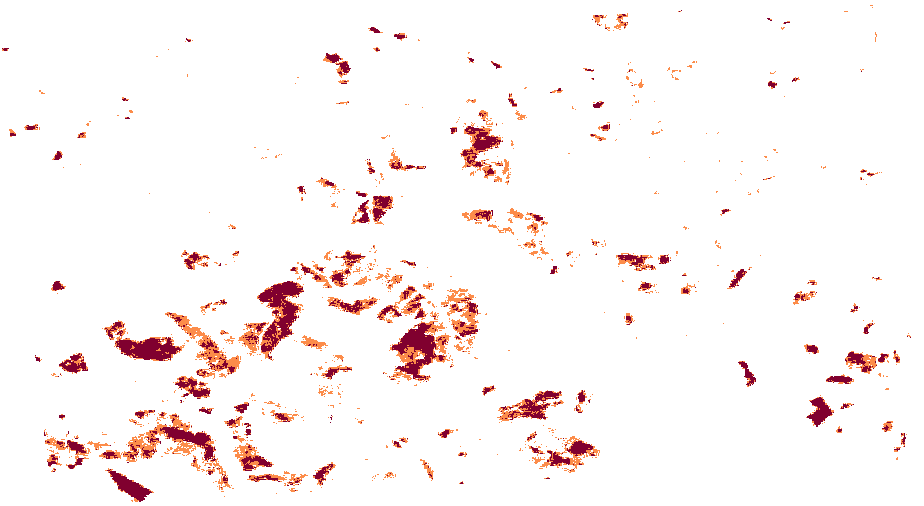
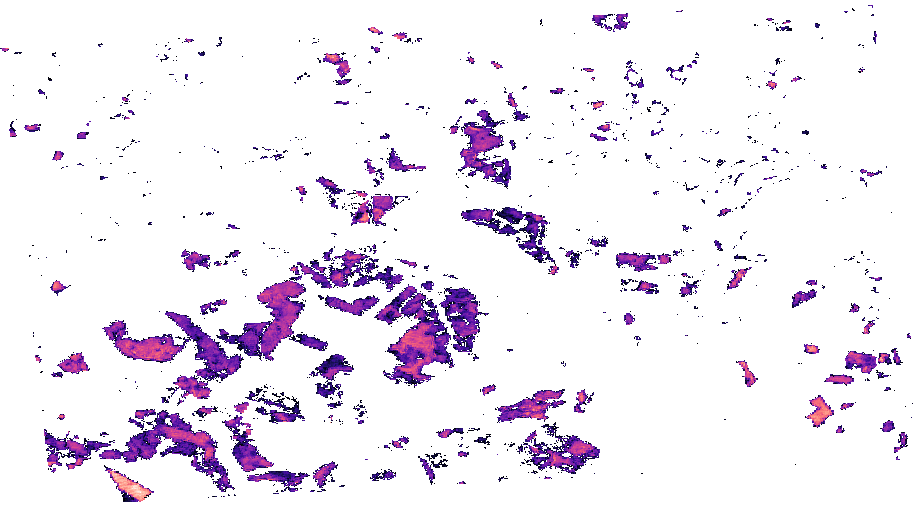

In [14]:
import folium
import numpy as np
from rasterio.enums import Resampling

def add_xarray_to_map(m, da, name, cmap_name='magma', vmin=None, vmax=None, opacity=0.9):
    """
    Reprojects an xarray DataArray, colorizes it, and adds it to a folium map.
    """
    # 1. Reproject to WGS84
    # Note: Using astype('float32') avoids the 'bool' KeyError
    da_4326 = (da.astype('float32')
               .rio.write_crs("EPSG:3035", inplace=True)
               .rio.reproject("EPSG:4326", resampling=Resampling.nearest))

    # 2. Get Bounds for Folium: [[min_lat, min_lon], [max_lat, max_lon]]
    b = da_4326.rio.bounds()
    bounds = [[b[1], b[0]], [b[3], b[2]]]

    # 3. Colorize the data
    data = da_4326.values
    v_min = vmin if vmin is not None else np.nanmin(data)
    v_max = vmax if vmax is not None else np.nanmax(data)

    norm = plt.Normalize(vmin=v_min, vmax=v_max)
    cmap = plt.get_cmap(cmap_name)
    rgba_data = cmap(norm(data))

    # 4. Add to map
    folium.raster_layers.ImageOverlay(
        image=rgba_data,
        bounds=bounds,
        opacity=opacity,
        name=name
    ).add_to(m)

    return bounds

# --- Main Logic ---

# Initialize Map
m = folium.Map(tiles=None)

# Add Satellite Basemap
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False
).add_to(m)

# Process layers using the function
classif_filtered = cc_detect.detection.classif.where(
    cc_detect.detection.classif.isin([1, 2, 3])
)

layers = [
    (cc_detect.detection.date_max,      "Change Date",      'viridis', None, None),
    (classif_filtered,                  "Change Classif",   'YlOrRd',  None, None),
    (cc_detect.detection.magnitude_max, "Change Magnitude", 'magma',   None, None),
]

last_bounds = None
for da, name, cmap, vmin, vmax in layers:
    last_bounds = add_xarray_to_map(m, da, name, cmap_name=cmap, vmin=vmin, vmax=vmax)

# Center the map automatically based on the last layer
if last_bounds:
    m.fit_bounds(last_bounds)

folium.LayerControl().add_to(m)
m

```
<div style="text-align: center;">
  <img src="img/cc_map.png" alt="clear-cut method" width="500">
</div>
```